### Noisy Batch Optimization

Many high performing materials suffer from poor corrosion resistance. Anti-corrosion coatings are a common solution that can be adapted to protect a given material in a number of harsh environments. You have the task of designing an anti-corrosion coating for a new material that needs to withstand a relatively high temperature corrosive environment. You decided to simulate the corrosive environment in the lab and test a number of different coatings to see which one performs the best. Based on the lab space, you see that you can specify up to nine coatings in a single test, allowing three replicates of three coating designs to be tested at once.

You believe Bayesian optimization can help you in this task and decide to put together an optimization script using Honegumi to help solve this problem.

Looking through the literature you identify the following tunable parameters for this problem:

| | **Parameter Name** | **Bounds**  |
|------|--------------------|-------------|
| x1   | Resin Fraction              | [0, 1]          |
| x2   | Inhibitor Fraction          | [0, 1]          |
| x3   | Insulator Fraction          | [0, 1]          |
| x4   | Stabilizer Fraction         | [0, 0.1]        |
| x5   | Coating Thickness           | [0.1, 10]       |

Additionally, you identify several constraints on the relative fractions of the different components based on prior work in the literature. Notably, you observe that the best materials keep `Resin Fraction` > `Inhibitor Fraction` > `Insulator Fraction` > `Stabilizer Fraction`.

A dummy objective function that emulates the results of the corrosion experiment has been constructed in the code cell below. To simulate sample variability, random noise is added to the output of the function on call. Although we can easily find optimal values using the equations, we will pretend that the objective function is unknown and use a Bayesian optimization approach to find the optimal set of input parameters instead.

In [317]:
import numpy as np

def simulate_corrosion(x1, x2, x3, x4, x5):
    """
    Calculate the corrosion damage based on the input parameters.

    Args:
        x1 (float): the fraction of resin used in the coating formulation
        x2 (float): the fraction of inhibitor used in the coating formulation
        x3 (float): the fraction of insulator used in the coating formulation
        x4 (float): the fraction of stabilizer used in the coating formulation
        x5 (float): the coating thickness

    Returns:
        dict: the measured corrosion damage and  uncertainty
    """
    score = float(
        1/(np.exp(-40*(x1-0.42)**2) + np.exp(-24*(x1-0.75)**2) + 0.1) +
        1/(np.exp(-30*(x2-0.22)**2) + np.exp(-1000*(x2-0.22)**2) + np.exp(-800*(x2-0.42)**2) + 0.15) +
        1/(np.exp(-25*(x3-0.27)**2) + np.exp(-1000*(x3-0.27)**2) + np.exp(-150*(x3-0.37)**2) +1) +
        1/(np.exp(-400*(x4-0.08)**2) +1) + 0.5*x4 +
        1/(np.exp(-(x5-8)**2) + 0.05*x5 + 0.3)
    ) - 3.18
    
    return (abs(score), np.random.uniform(0.01, 0.1))

## Applying Honegumi

We will now use the [Honegumi website](https://honegumi.readthedocs.io/en/latest/) to generate a script that will help us optimize the coating parameters. From the description, we observe that our problem is a **single objective** optimization problem with a **constraint on the fractional sum of coating components** and an **ordering constraint** on the relative fractions of each component. As there is room for several samples to be tested in parallel, **batch optimization** could make the approach more efficient. Lastly, it is expected that the reults will be noisy, so you decide to use a **Fully Bayesian** model to make the optimization process more robust.

![Honegumi Selections for The Problem Statement](Selection-1.jpg)

The Honegumi generated optimization script will provide a framework for our optimization campaign that we can modify to suit our specific problem needs. In the code sections below, we will make several modifications to this generated script to make it compatible with our problem.

## Modifying the Code for Our Problem

We can modify this code to suit our problem with a few simple modifications. Wherever a modification has been made to the code, a comment starting with `# CHANGE:` has been added along with a brief description of the change.

In [337]:
import numpy as np
from ax.service.ax_client import AxClient, ObjectiveProperties

from ax.modelbridge.factory import Models
from ax.modelbridge.generation_strategy import GenerationStep, GenerationStrategy


obj1_name = "corrosion_score" # CHANGE: update objective name

# CHANGE: remove the branin dummy objective function, we will use the above function

total = 1.0 # CHANGE: update total component fraction


gs = GenerationStrategy(
    steps=[
        GenerationStep(
            model=Models.SOBOL,
            num_trials=6,
            min_trials_observed=3,
            max_parallelism=5,
            model_kwargs={"seed": 999},
            model_gen_kwargs={},
        ),
        GenerationStep(
            model=Models.FULLYBAYESIAN,
            num_trials=-1,
            max_parallelism=3,
            should_deduplicate=True, # CHANGE: reduce duplicate suggestions
            model_kwargs={"num_samples": 1024, "warmup_steps": 1024}, # CHANGE: increase
        ),
    ]
)

ax_client = AxClient(generation_strategy=gs, random_seed=42) # CHANGE: add random seed for reproducibility

ax_client.create_experiment(
    parameters=[
        {"name": "x1", "type": "range", "bounds": [0.0, total]}, # CHANGE: update parameter
        {"name": "x2", "type": "range", "bounds": [0.0, total]}, # CHANGE: update parameter
        {"name": "x3", "type": "range", "bounds": [0.0, total]}, # CHANGE: add new parameter
        {"name": "x5", "type": "range", "bounds": [0.1, 10.0]}, # CHANGE: add new parameter
    ],
    objectives={
        obj1_name: ObjectiveProperties(minimize=True),
    },
    parameter_constraints=[
        f"x1 + x2 + x3 <= {total}", # CHANGE: update composition constraint
        "x1 >= x2", # CHANGE: update order constraint
        "x1 >= x3", # CHANGE: add order constraint
    ],
)

batch_size = 2

for _ in range(10): # CHANGE: decrease number of iterations

    parameterizations, optimization_complete = ax_client.get_next_trials(batch_size)
    for trial_index, parameterization in list(parameterizations.items()):
        
        # CHANGE: pull all added parameters from the parameterization
        x1 = parameterization["x1"]
        x2 = parameterization["x2"]
        x3 = parameterization["x3"]
        x4 = total - (x1 + x2 + x3) # CHANGE: update composition constraint
        x5 = parameterization["x5"]

        results = simulate_corrosion(x1, x2, x3, x4, x5)
        ax_client.complete_trial(trial_index=trial_index, raw_data=results)

best_parameters, metrics = ax_client.get_best_parameters()

[INFO 05-01 08:47:30] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.
[WARNING 05-01 08:47:30] ax.service.ax_client: Random seed set to 42. Note that this setting only affects the Sobol quasi-random generator and BoTorch-powered Bayesian optimization models. For the latter models, setting random seed to the same number for two optimizations will make the generated trials similar, but not exactly the same, and over time the trials will diverge more.
[INFO 05-01 08:47:30] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter x1. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 05-01 08:47:30] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter x2. If that is not the expected val

### Show the Best Parameters

After our optimization loop has completed, we can use the model to find the best parameters and their corresponding strength value. These will be our optimial set of parameters that we use in the 3D printer going forward.

In [338]:
ax_client.get_best_trial()

Sample: 100%|██████████| 2048/2048 [00:42, 47.73it/s, step size=2.50e-01, acc. prob=0.877]


(19,
 {'x1': 0.5531141417704178,
  'x2': 0.1846591406143514,
  'x3': 0.26222671761513805,
  'x5': 8.2901097602077},
 ({'corrosion_score': 0.41040928033269086},
  {'corrosion_score': {'corrosion_score': 0.0008997393689987544}}))

### Plotting Optimization Performance

We can plot the performance of our optmization loop to see how the optimization task progressed as a function of iteration count.

[WARNING 05-01 08:58:34] ax.service.utils.report_utils: Column reason missing for all trials. Not appending column.


(0.0, 2.0)

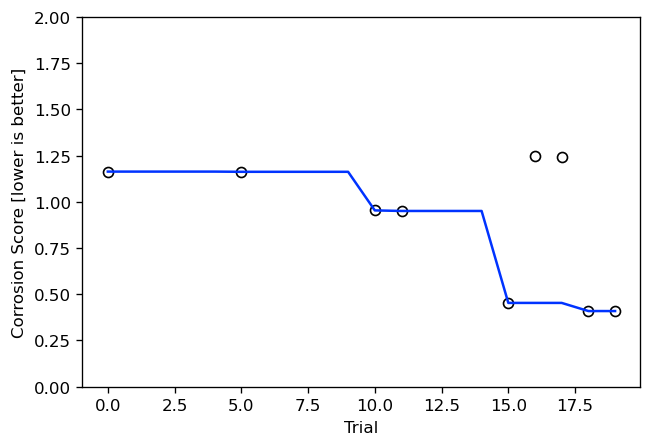

In [339]:
import matplotlib.pyplot as plt
h_blue = '#0033FF'

df = ax_client.get_trials_data_frame()
fig, ax = plt.subplots(figsize=(6,4), dpi=120)
ax.plot(df.corrosion_score.values, ls='None', marker='o', mfc='none', mec='black')
ax.plot(np.minimum.accumulate(df.corrosion_score.values), color=h_blue)
plt.xlabel('Trial')
plt.ylabel('Corrosion Score [lower is better]')
plt.ylim(0, 2)

In [340]:
from ax.modelbridge.cross_validation import cross_validate
from ax.plot.diagnostic import interact_cross_validation

model = ax_client.generation_strategy.model
cv_results = cross_validate(model)
render(interact_cross_validation(cv_results))

In [325]:
cv_results

[CVResult(observed=<ax.core.observation.Observation object at 0x2a5c793d0>, predicted=ObservationData(metric_names=['corrosion_score'], means=[3.33038581], covariance=[[0.0086991]])),
 CVResult(observed=<ax.core.observation.Observation object at 0x2a5c79df0>, predicted=ObservationData(metric_names=['corrosion_score'], means=[3.38045204], covariance=[[1.14749778]])),
 CVResult(observed=<ax.core.observation.Observation object at 0x2a9d89430>, predicted=ObservationData(metric_names=['corrosion_score'], means=[1.57425067], covariance=[[0.00012101]])),
 CVResult(observed=<ax.core.observation.Observation object at 0x2a5c79cd0>, predicted=ObservationData(metric_names=['corrosion_score'], means=[3.74291177], covariance=[[0.00775312]])),
 CVResult(observed=<ax.core.observation.Observation object at 0x2a5c797f0>, predicted=ObservationData(metric_names=['corrosion_score'], means=[3.35092202], covariance=[[0.00104975]])),
 CVResult(observed=<ax.core.observation.Observation object at 0x2a2ab1a90>, 